In [1]:
import glob
from matplotlib import pyplot as plt

root_dir = "/home/max/Documents/Classwork/Networks/pcap_samples"
splits=["train", "test"]

In [2]:
import numpy as np
import pandas as pd

dataset_files = {split: {} for split in splits}

classes = [
    "git-tunnel",
    "http-tunnel",
    "browser-tunnel",
    "ssh-file",
    "ssh-interactive",
    "x11-tunnel"
]

test_strings = ["-5."]


def separate_multiclass_data(root_dir):
    for folder in glob.glob(f"{root_dir}/**/"):
        folder_label = None
        for i in range(len(classes)):
            print(classes[i], folder)
            if classes[i] in folder:
                folder_label = i
                dataset_files["test"][folder_label] = []
                dataset_files["train"][folder_label] = []

        for file in glob.glob(f"{folder}*.csv", recursive=True):
            test_file = False
            for string in test_strings:
                if string in file:
                    test_file = True
                    break
            
            if test_file:
                dataset_files["test"][folder_label].append(file)
            else:
                dataset_files["train"][folder_label].append(file)

        
def separate_binary_data(root_dir):
    for split in splits:
        dataset_files[split][0] = []
        dataset_files[split][1] = []
    for folder in glob.glob(f"{root_dir}/**/"):
        folder_label = 1 if "tunnel" in folder else 0
        for file in glob.glob(f"{folder}*.csv", recursive=True):
            test_file = False
            for string in test_strings:
                if string in file:
                    test_file = True
                    break
            
            if test_file:
                dataset_files["test"][folder_label].append(file)
            else:
                dataset_files["train"][folder_label].append(file)

In [3]:
separate_binary_data(root_dir="/home/max/Documents/Classwork/Networks/all_samples")
dataset_files

{'train': {0: ['/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/real-world-ssh-interactive-use-example-capture.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-3.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-2.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-1.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-3.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-4.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-4.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized.csv',
   '/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomize

In [4]:
def create_datapoint(df, start_idx, window_size, label=None):
    
    # extract the relevant rows from the DataFrame
    window_df = df.iloc[start_idx:start_idx+window_size]
    
    # compute the metrics
    src_sum = window_df['src'].sum()
    length_min = window_df['length'].min()
    length_max = window_df['length'].max()
    length_mean = window_df['length'].mean()
    length_std = window_df['length'].std()
    length_range = length_min - length_max
    timestamp_diff = np.diff(window_df['timestamp'])
    timestamp_diff_min = timestamp_diff.min()
    timestamp_diff_max = timestamp_diff.max()
    timestamp_diff_mean = timestamp_diff.mean()
    timestamp_diff_std = timestamp_diff.std()
    timestamp_diff_range = timestamp_diff_min - timestamp_diff_max

    metrics = [
        src_sum, length_mean, length_std,
        length_min, length_max, 
        # length_range, 
        timestamp_diff_min, timestamp_diff_max, 
        timestamp_diff_mean, timestamp_diff_std, 
        # timestamp_diff_range
              ]
    
    if label is not None:
        metrics.append(label)
    # return the metrics as a numpy array
    return np.array(metrics)

In [5]:
# from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Your code goes here for this section.

data_pipeline = StandardScaler()


In [6]:
from typing import List, Dict

def create_dataset(dset_files: Dict[int, List[str]], window_size: int, stride: int, pipeline, separate_labels=True, train=True) -> np.ndarray:
    dset_list = []
    
    if separate_labels:
        label_list = []
    
    for label in dset_files.keys():
        csv_paths = dset_files[label]
    
        for csv_path in csv_paths:
            
            print(csv_path)
            # read in the csv file and convert to DataFrame
            df = pd.read_csv(csv_path, index_col=0)

            # loop over all allowable start_idx values separated by stride
            for start_idx in range(0, len(df) - window_size + 1, stride):
                # compute metrics for the current window
                if separate_labels:
                    datapt = create_datapoint(df, start_idx, window_size)
                    label_list.append(label)
                else:
                    datapt = create_datapoint(df, start_idx, window_size, label=label)
                dset_list.append(datapt)
    
    # concatenate the resulting arrays row-wise
    dset = np.vstack(dset_list)
    
    if train:
        pipeline.fit_transform(dset)
    else:
        pipeline.transform(dset)
    
    if separate_labels:
        labels = np.array(label_list)
        return dset, labels
    else:
        return dset

In [7]:
window_size = 100
stride = 10

X_train, Y_train = create_dataset(dataset_files["train"], window_size=window_size, stride=stride, pipeline=data_pipeline, separate_labels=True)
X_test, Y_test = create_dataset(dataset_files["test"], window_size=window_size, stride=stride, pipeline=data_pipeline, separate_labels=True)

/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/real-world-ssh-interactive-use-example-capture.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-3.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-2.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-1.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-3.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized-4.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-4.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/ssh-interactive-randomized.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-interactive/UNSEEN-ssh-interactive-randomized-2.csv
/home/max/Documents/Classwork/Networks/all_samples/ssh-f

In [8]:
np.round(X_train[0:10], 2)

array([[4.600000e+01, 2.495400e+02, 3.803000e+02, 6.600000e+01,
        1.630000e+03, 0.000000e+00, 2.231000e+01, 5.000000e-01,
        2.950000e+00],
       [4.500000e+01, 2.853200e+02, 4.252800e+02, 6.600000e+01,
        1.630000e+03, 0.000000e+00, 2.231000e+01, 3.300000e-01,
        2.410000e+00],
       [4.600000e+01, 2.542000e+02, 3.793100e+02, 6.600000e+01,
        1.630000e+03, 0.000000e+00, 2.231000e+01, 3.300000e-01,
        2.420000e+00],
       [4.600000e+01, 2.602800e+02, 3.835400e+02, 6.600000e+01,
        1.630000e+03, 0.000000e+00, 2.231000e+01, 3.300000e-01,
        2.420000e+00],
       [4.500000e+01, 5.766400e+02, 1.801750e+03, 6.600000e+01,
        1.454600e+04, 0.000000e+00, 2.231000e+01, 3.300000e-01,
        2.420000e+00],
       [4.600000e+01, 1.558120e+03, 4.936040e+03, 6.600000e+01,
        3.287000e+04, 0.000000e+00, 2.231000e+01, 2.300000e-01,
        2.230000e+00],
       [4.700000e+01, 2.831820e+03, 7.878620e+03, 6.600000e+01,
        4.495400e+04, 0.000000

In [9]:
sum(Y_test) / len(Y_test)

0.394860349863796

In [10]:
from sklearn.linear_model import *
from sklearn.metrics import confusion_matrix

In [11]:
from sklearn.linear_model import *

lin_reg = LinearRegression().fit(X_train, Y_train)

In [12]:
print("Linear model train accuracy:", sum(np.round(lin_reg.predict(X_train)) ==Y_train) / len(Y_train))
print("Linear model test accuracy:", sum(np.round(lin_reg.predict(X_test)) ==Y_test) / len(Y_test))

Linear model train accuracy: 0.8977287161411197
Linear model test accuracy: 0.9579080376776395


In [13]:
print(confusion_matrix(Y_train, np.round(lin_reg.predict(X_train))))
print(confusion_matrix(Y_test, np.round(lin_reg.predict(X_test))))

[[     0      0      0      0      0      0]
 [    37  89080   8425      9      0     35]
 [    68  16873 137083    316      2      0]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]]
[[    0     0     0     0]
 [    1 36242   620    13]
 [   21  1827 22131    83]
 [    0     0     0     0]]


In [14]:
log_reg = LogisticRegression().fit(X_train, Y_train)

In [15]:
print("Logistic model train accuracy:", log_reg.score(X_train, Y_train))
print("Logistic model test accuracy:", log_reg.score(X_test, Y_test))

Logistic model train accuracy: 0.8548315391699216
Logistic model test accuracy: 0.917063244609275


In [16]:
print(confusion_matrix(Y_train, np.round(log_reg.predict(X_train))))
print(confusion_matrix(Y_test, np.round(log_reg.predict(X_test))))

[[ 89420   8166]
 [ 28406 125936]]
[[36198   678]
 [ 4376 19686]]


In [17]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier().fit(X_train, Y_train)

In [18]:
print("Tree model train accuracy:", tree_model.score(X_train, Y_train))
print("Tree model test accuracy:", tree_model.score(X_test, Y_test))

Tree model train accuracy: 1.0
Tree model test accuracy: 0.997308740030851


In [19]:
print(confusion_matrix(Y_train, np.round(tree_model.predict(X_train))))
print(confusion_matrix(Y_test, np.round(tree_model.predict(X_test))))

[[ 97586      0]
 [     0 154342]]
[[36776   100]
 [   64 23998]]


In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=200, max_depth=4).fit(X_train, Y_train)

In [21]:
print("Forest model train accuracy:", forest_model.score(X_train, Y_train))
print("Forest model test accuracy:", forest_model.score(X_test, Y_test))

Forest model train accuracy: 0.974353783620717
Forest model test accuracy: 0.9942728675046769


In [22]:
print(confusion_matrix(Y_train, np.round(forest_model.predict(X_train))))
print(confusion_matrix(Y_test, np.round(forest_model.predict(X_test))))

[[ 91749   5837]
 [   624 153718]]
[[36646   230]
 [  119 23943]]


In [23]:
print(Y_test)

[0 0 0 ... 1 1 1]


In [48]:
import random

realtime_files = dataset_files["test"][1] + dataset_files["test"][0]
random.shuffle(realtime_files)

realtime_data = [pd.read_csv(filename) for filename in realtime_files]

x = [[int("tunnel" in realtime_files[i])] * len(realtime_data[i])
                      for i in range(len(realtime_files))]
realtime_labels = []
for label_slice in x:
    realtime_labels += label_slice

In [50]:
times = []
for i in range(len(realtime_files)):
    if len(realtime_data[i]) > 60100:
        times.append(realtime_data[i]["timestamp"][60100]-realtime_data[i]["timestamp"][100])

In [25]:
realtime_data = pd.concat(realtime_data)

In [53]:
np.mean(times)

7.9738611578941345

In [41]:
data_samples = range(0, len(realtime_labels)-window_size, 10)
X_samp = [create_datapoint(realtime_data, samp, window_size) for samp in data_samples]
Y_samp = [realtime_labels[samp:samp+window_size][-1] for samp in data_samples]

In [47]:
import time

t0 = time.time()
for i in range(len(X_samp[:60000])):
    tree_model.predict(X_samp[i:i+1])
print(time.time()-t0, len(X_samp))

2.0624661445617676 61004


In [38]:
from matplotlib import pyplot as plt

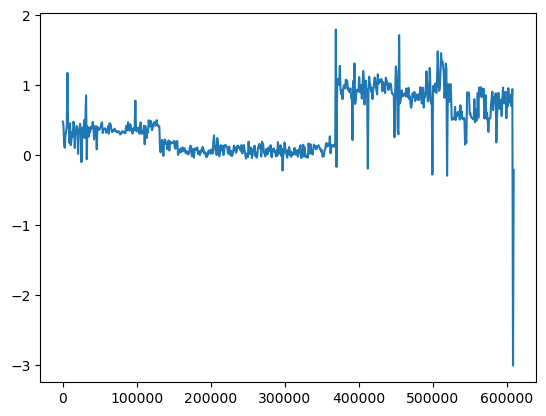

In [40]:
plt.plot(data_samples, np.clip(lin_reg.predict(X_samp), -3, 3))